# European Option Greeks estimation with Newton-Ralphson's Method, visualized with Greeks Surface Plot.

In [1]:
%pip install yfinance
%pip install fredapi

Note: you may need to restart the kernel to use updated packages.



#### Basic Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import datetime as dt
from scipy.stats import norm
from scipy.interpolate import interp1d, griddata
from scipy.optimize import brentq
import datetime
from datetime import timedelta, date
import plotly.graph_objects as go

In [3]:
def option_chains(ticker, T, type, price_range = 0.15):
    """
    Download all option chains with expiration up to T, number of years ahead, 
    for a given ticker and condense into a dataframe and filters out options 
    with low volume.

    Parameters
    ----------
    ticker : str
        Ticker symbol of the stock
    T : float
        Number of years ahead
    type : str
    Option type, 'c' for calls, 'p' for puts
    price_range : float, optional
    Range of strike prices to consider from current market price, by default 0.15

    Returns
    -------
    pd.DataFrame
        DataFrame containing the option chains with columns ['K', 'Price', 'T', 'S0']
        for easy vector operations
    """
    yticker = yf.Ticker(ticker)
    expirations = yticker.options
    current_price = yticker.info['regularMarketPrice']
    option_chain = pd.DataFrame(columns = ['strike', 'lastPrice', 'T'])
    for dates in range(len(expirations)):
        time_to_expiry = (datetime.datetime.strptime(expirations[dates], '%Y-%m-%d') - datetime.datetime.now()).days / 365
        if time_to_expiry > T: # first checks for expiry date to reduce computation time
            break
        if type == 'c':
            option_week_df = yticker.option_chain(str(expirations[dates])).calls
        elif type == 'p':
            option_week_df = yticker.option_chain(str(expirations[dates])).puts
        else:
            raise ValueError('Invalid option type, only accepts c or p')
        option_week_df['T'] = time_to_expiry
        option_chain = pd.concat([option_chain, option_week_df[['strike', 'lastPrice', 'T', 'volume']]], ignore_index=True)
    # look at options centered around current price
    option_chain_ranged = option_chain[(option_chain['strike'] / current_price - 1).abs() <= price_range]
    option_chain_ranged['S0'] = current_price
    option_chain_ranged.columns = ['K', 'Price', 'T', 'Volume','S0']
    # remove options with low volume, filter out the bottom 25 percentile.
    option_chain_ranged = option_chain_ranged[option_chain_ranged['Volume'] >= np.percentile(option_chain_ranged['Volume'], 25)]
    option_chain_ranged.reset_index(drop = True, inplace = True)
    return option_chain_ranged

In [4]:
option_chains = option_chains('AAPL', 0.5, 'c', price_range = 0.15)
option_chains

C:\Users\samuel\AppData\Local\Temp\ipykernel_12716\1901140516.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_chain = pd.concat([option_chain, option_week_df[['strike', 'lastPrice', 'T', 'volume']]], ignore_index=True)
C:\Users\samuel\AppData\Local\Temp\ipykernel_12716\1901140516.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_chain_ranged['S0'] = current_price


,K,Price,T,Volume,S0
0,240.0,32.25,0.002740,52.0,272.36
1,250.0,22.10,0.002740,379.0,272.36
2,260.0,12.44,0.002740,767.0,272.36
3,262.5,9.95,0.002740,86.0,272.36
4,265.0,7.56,0.002740,3959.0,272.36
...,...,...,...,...,...
146,290.0,12.22,0.479452,1450.0,272.36
147,295.0,10.26,0.479452,56.0,272.36
148,300.0,8.80,0.479452,404.0,272.36
149,305.0,7.35,0.479452,47.0,272.36


In [5]:
# extract latest money market rates from Fred as Risk Free Rate.
with open(r"FRED_api_key.txt", 'r') as file:
    api_key = file.read()
fred = Fred(api_key = api_key)
start_fred = (datetime.datetime.today() - datetime.timedelta(days = 10)).strftime('%Y-%m-%d')
end_fred = datetime.datetime.today().strftime('%Y-%m-%d')
money_market_rates = fred.get_series("DCPF1M", observation_start = start_fred, observation_end = end_fred)
money_market_rates.dropna(inplace = True)
rf = money_market_rates.iloc[-1] / 100
print("Current Money Market Rates as of ", money_market_rates.index[-1].strftime('%Y-%m-%d'), "is: ", rf)

Current Money Market Rates as of  2025-12-18 is:  0.0366


In [6]:
def bsm_option_price(S0, K, T, r, iv, type):
    """
    We use the BSM European Option Pricing model in this case.
    """
    d1 = (np.log(S0 / K) + (r + iv ** 2 / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    if type == 'c':
        call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'p':
        call_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return call_price
    

In [7]:
def bsm_vega(S0, K, T, r, iv):
    """ 
    Vega is the slope of Price vs IV curve 
    """
    d1 = (np.log(S0 / K) + (r + iv ** 2 / 2) * T) / (iv * np.sqrt(T))
    vega = S0 * norm.pdf(d1) * np.sqrt(T)
    return vega

In [8]:
def bsm_delta(S0, K, T, r, iv, type):
    """
    Delta is the sensitivity of the option price to the underlying asset price 
    """
    d1 = (np.log(S0 / K) + (r + iv ** 2 / 2) * T) / (iv * np.sqrt(T))
    if type == 'c':
        delta = norm.cdf(d1)
    elif type == 'p':
        delta = norm.cdf(d1) - 1
    return delta

In [9]:
def bsm_gamma(S0, K, T, r, iv):
    """
    Gamma is the sensitivity of the change of Delta to the change of underlying price
    """
    d1 = (np.log(S0 / K) + (r + iv ** 2 / 2) * T) / (iv * np.sqrt(T))
    gamma = norm.pdf(d1) / (S0 * iv * np.sqrt(T))
    return gamma

In [10]:
def bsm_theta(S0, K, T, r, iv, type):
    """"
    Time sensitivity of the option price
    """

    d1 = (np.log(S0 / K) + (r + iv ** 2 / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    if type == 'c':
        theta = -norm.pdf(d1) * S0 * iv / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    elif type == 'p':
        theta = -norm.pdf(d1) * S0 * iv / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)
    return theta

In [11]:
def bsm_rho(S0, K, T, r, iv):
    """
    Interest rate sensitivity of the option price 
    """
    d1 = (np.log(S0 / K) + (r + iv ** 2 / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    return rho

In [12]:
def iv_newton_ralphson_estimation(S0, K, T, r, initial_guess_iv, market_price, type, max_iter = 200, tolerance = 0.00001):
    """ We try to find the root of the objective function: BSM call price - market_price = 0,
        where the variables will be Price vs IV.
        Therefore, objective function is 
        f(iv) = BSM call price - Market Price, 
        and as Market Price is constant,
        f'(iv) = BSM Vega.

        Therefore the estimation method is as follows, 
        Next IV Estimate = Old IV Estimate - f(iv)/f'(iv)

        If the Newton-Raphson method fails to converge, we use the Brent's method instead.

        We prioritize Newton-Ralphson method for its speed, but Brent's method is more
        robust, therefore it is used as a fallback.

        parameters:
            S0: current stock price
            K: strike price
            T: time to maturity
            r: risk free rate
            initial_guess_iv: initial guess for IV
            market_price: market price of the option
            type: 'c' for call, 'p' for put
            max_iter: maximum number of iterations
            tolerance: tolerance for convergence for Newton-Raphson method

        returns:
            iv_trial: estimated IV given the parameters of the current option.
    """
    
    iv_trial = initial_guess_iv
    for i in range(max_iter):
        intrinsic_value = max(0, S0 - K)
        if market_price < intrinsic_value: # if market price is less than intrinsic value, instantly return NAN
            iv_trial = np.nan
            break
        price = bsm_option_price(S0, K, T, r, iv_trial, type)
        vega = bsm_vega(S0, K, T, r, iv_trial)
        if abs(vega) < 1e-8: # if vega is too small, we switch to Brent's method to prevent division by zero
            iv_trial = brentq(lambda brent_iv: bsm_call_price(S0, K, T, r, brent_iv, type) - market_price, 0.0001, 2)
            break
        iv_trial = iv_trial - (price - market_price) / vega # Next IV Estimate = Old IV Estimate - f(iv)/f'(iv)
        if abs(iv_trial - iv_trial) < tolerance: # convergence check if iv_trial is close enough to the previous iv_trial
            break
    return iv_trial
    

In [13]:
def get_greeks(df, rf, type):
    """
    Vectorized operation to derive IV (using Newton-Raphson method), and greeks,
    for efficiency.
    
    We also drop NAs in computing greeks, as they are deemed to be invalid.

    parameters:
    df: DataFrame containing the following columns:
        S0: Spot price
        K: Strike price
        T: Time to maturity
        Price: Market price
    rf: Risk-free rate
    type: Option type ("c" or "p")

    returns:
    df: DataFrame containing the following columns:
        S0: Spot price
        K: Strike price
        T: Time to maturity
        Price: Market price
        rf: Risk-free rate
        log_moneyness: Log moneyness
        iv: Implied volatility
        delta: Delta
        gamma: Gamma
        vega: Vega
        theta: Theta
        rho: Rho
    """
    S0 = df['S0'].values
    K = df['K'].values
    T = df['T'].values
    Price = df['Price'].values
    df['rf'] = rf

    df['log_moneyness'] = np.log(K / S0)
    
    vec_iv_func = np.vectorize(iv_newton_ralphson_estimation)
    
    df['iv'] = vec_iv_func(S0, K, T, rf, 0.5, Price, type)

    iv_array = df['iv'].values
    
    df['delta'] = bsm_delta(S0, K, T, rf, iv_array, type)
    df['gamma'] = bsm_gamma(S0, K, T, rf, iv_array)
    df['vega']  = bsm_vega(S0, K, T, rf, iv_array)
    df['theta'] = bsm_theta(S0, K, T, rf, iv_array, type)
    df['rho']   = bsm_rho(S0, K, T, rf, iv_array)

    df.dropna(inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [14]:
df_greeks = get_greeks(option_chains, rf,'c')
df_greeks

,K,Price,T,Volume,S0,rf,log_moneyness,iv,delta,gamma,vega,theta,rho
0,260.0,12.44,0.002740,767.0,272.36,0.0366,-0.046443,0.455366,0.975273,0.008921,0.825560,-77.873903,0.693639
1,262.5,9.95,0.002740,86.0,272.36,0.0366,-0.036874,0.409737,0.958605,0.015169,1.263149,-103.644680,0.687946
2,265.0,7.56,0.002740,3959.0,272.36,0.0366,-0.027395,0.389165,0.913082,0.028520,2.255700,-169.029171,0.660484
3,267.5,4.95,0.002740,1131.0,272.36,0.0366,-0.018005,0.283573,0.890131,0.046474,2.678342,-147.296363,0.650229
4,270.0,2.89,0.002740,15006.0,272.36,0.0366,-0.008703,0.258281,0.744704,0.087262,4.580510,-223.223873,0.547595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,290.0,12.22,0.479452,1450.0,272.36,0.0366,0.062756,0.232579,0.420663,0.008915,73.743348,-21.629956,49.041901
145,295.0,10.26,0.479452,56.0,272.36,0.0366,0.079851,0.231010,0.378464,0.008729,71.717144,-20.665611,44.384740
146,300.0,8.80,0.479452,404.0,272.36,0.0366,0.096658,0.234252,0.342142,0.008314,69.266315,-19.993157,40.242919
147,305.0,7.35,0.479452,47.0,272.36,0.0366,0.113187,0.235877,0.307164,0.007899,66.265536,-19.067924,36.254472


In [15]:
def plot_iv_vs_log_moneyness(T, df):
    """
    Function is used to observe IV against Log Moneyness of an option to check if
    the Newton-Ralphson method is working as intended.

    Parameters
    ----------
    T : float
        Exact time to expiration in years from the option chain, recommended to use
        df['T'].unique()[i] where i is the number of weeks to expiration.
    df : DataFrame
        DataFrame containing option data as obtained from the get_greeks function.
    """
    df = df[df['T'] == T]
    plt.figure(figsize=(4, 4))

    x = df['log_moneyness'].values
    y = df['iv'].values

    #scatter plot of IV vs log-moneyness
    plt.scatter(x, y, alpha=0.6, s=10)

    #interpolation of IV curve
    x_axis = np.linspace(x.min(), x.max(), 100)
    coeffs_iv = np.polyfit(x, y, 4)
    poly_iv = np.poly1d(coeffs_iv)
    simulated_iv = poly_iv(x_axis)
    interpolated_iv_df = pd.DataFrame({'log_moneyness': x_axis, 'iv': simulated_iv})

    #plotting interpolated IV curve
    plt.plot(interpolated_iv_df['log_moneyness'], interpolated_iv_df['iv'], 'r', alpha = 0.6)

    plt.xlabel('Log-Moneyness [ln(S/K)]')
    plt.ylabel('Implied Volatility [IV]')
    plt.title('IV vs Log-Money for T = ' + str(round(T * 365)) + ' days to expiration')
    plt.grid(True, alpha = 0.4)
    plt.show()
    

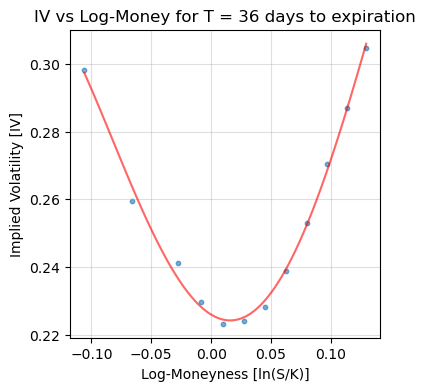

In [16]:
plot_iv_vs_log_moneyness(df_greeks['T'].unique()[5], df_greeks)

In [17]:
def plot_greeks_surface(df, greek='iv'):
    x = df['log_moneyness'].values
    y = df['T'].values
    z = df[greek].values

    # Filter out outliers above the 95th percentile, remove noise
    mask = z <= np.percentile(z, 95)
    x, y, z = x[mask], y[mask], z[mask]

    # define grid of x = log_moneyness and y = T. high resolution not required.
    x_axis = np.linspace(x.min(), x.max(), 50)
    y_axis = np.linspace(y.min(), y.max(), 50)
    X_interpolated, Y_interpolated = np.meshgrid(x_axis, y_axis)

    # smooth interpolation with cubic method
    Z_interpolated = griddata((x, y), z, (X_interpolated, Y_interpolated), method='cubic')

    # plot surface
    fig = go.Figure(data=[go.Surface(
        z = Z_interpolated, 
        x = X_interpolated, 
        y = Y_interpolated,
        colorscale = 'Viridis',
        connectgaps = True
    )])

    fig.update_layout(
        title = f'{greek.upper()} Surface Plot with Interpolation',
        scene = dict(
            xaxis_title = 'Log Moneyness',
            yaxis_title = 'Time to Expiration (T)',
            zaxis_title = greek.upper()
        ),
        width=900,
        height=800
    )
    
    fig.show()

In [18]:
plot_greeks_surface(df_greeks, greek = 'iv')

In [19]:
plot_greeks_surface(df_greeks, greek = 'gamma')

In [20]:
plot_greeks_surface(df_greeks, greek = 'rho')

In [21]:
plot_greeks_surface(df_greeks, greek = 'delta')

In [22]:
plot_greeks_surface(df_greeks, greek = 'vega')

In [23]:
plot_greeks_surface(df_greeks, greek = 'theta')